In [1]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Resizing
from keras.models import Model
from keras.utils import plot_model

In [ ]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input, UpSampling2D, BatchNormalization
from keras.layers import Activation, Concatenate, Conv2D, Multiply

def channel_attention_module(x, ratio=8):
  batch,_,_,channel = x.shape

  #Shared layers
  l1 = Dense(channel//ratio, activation="relu", use_bias=False)
  l2 = Dense(channel, use_bias=False)

  ## Global Average Pooling
  x1 = GlobalAveragePooling2D()(x)
  x1 = l1(x1)
  x1 = l2(x1)

  ## Global Max Pooling
  x2 = GlobalMaxPooling2D()(x)
  x2 = l1(x2)
  x2 = l2(x2)

  ## Add both the features and pass through sigmoid
  feats = x1 + x2
  feats = Activation("sigmoid")(feats)
  feats = Multiply()([x, feats])

  return feats

def spatial_attention_module(x):
  ## Average Pooling
  x1 = tf.reduce_mean(x, axis=-1)
  x1 = tf.expand_dims(x1, axis=-1)

  ## Max Pooling
  x2 = tf.reduce_max(x, axis=-1)
  x2 = tf.expand_dims(x2, axis=-1)

  ## Concatenat both the features
  feats = Concatenate()([x1, x2])
  ## Conv layer
  feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
  feats = Multiply()([x, feats])

  return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x


# Implementation 01

In [ ]:
input_layer_1 = Input(shape=(512,512,1)) # input_image with one layer (2D image)
input_layer_2 = Input(shape=(256,256,1))
input_layer_3 = Input(shape=(128,128,1))
input_layer_4 = Input(shape=(64,64,1))

# block_01 (Encoder_Layer_01)
b01_con1 = Conv2D(256, (7, 7), activation="relu", padding="same", name='b01_con1')(input_layer_1)
b01_con2 = Conv2D(256, (7, 7), activation="relu", padding="same", name='b01_con2')(b01_con1)

b01_pool = MaxPooling2D((2, 2), name='b01_pool')(b01_con2)
b01_drop = Dropout(0.25, name='b01_drop')(b01_pool)

# block_02 (Encoder_Layer_02)
b02_Incon1 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b02_Incon1')(input_layer_2)
b02_Incon2 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b02_Incon2')(b02_Incon1)

b02_concat = concatenate([b02_Incon2, b01_drop], name='b02_concat')

b02_con1 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b02_con1')(b02_concat)
b02_con2 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b02_con2')(b02_con1)

b02_maxpool = MaxPooling2D((2, 2), name='b02_maxpool')(b02_con2)
b02_drop = Dropout(0.25, name='b02_drop')(b02_maxpool)

# block_03 (Encoder_Layer_03)
b03_Incon1 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b03_Incon1')(input_layer_3)
b03_Incon2 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b03_Incon2')(b03_Incon1)

b03_concat = concatenate([b03_Incon2, b02_drop], name='b03_concat')

b03_con1 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b03_con1')(b03_concat)
b03_con2 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b03_con2')(b03_con1)

b03_maxpool = MaxPooling2D((2, 2), name='b03_maxpool')(b03_con2)
b03_drop = Dropout(0.25, name='b03_drop')(b03_maxpool)

# block_04 (Encoder_Layer_04 middle)
b04_Incon1 = Conv2D(32, (7, 7), activation="relu", padding="same", name='b04_Incon1')(input_layer_4)
b04_Incon2 = Conv2D(32, (7, 7), activation="relu", padding="same", name='b04_Incon2')(b04_Incon1)

b04_concat = concatenate([b04_Incon2, b03_drop], name='b04_concat')

b04_con1 = Conv2D(32, (7, 7), activation="relu", padding="same", name='b04_con1')(b04_concat)
b04_con2 = Conv2D(32, (7, 7), activation="relu", padding="same", name='b04_con2')(b04_con1)

b04_drop = Dropout(0.25, name='b04_drop')(b04_con2)

# block_05 (Decoder_Layer_01)
b05_conT = Conv2DTranspose(64, (7, 7), strides=(2, 2), padding="same", name='b05_conT')(b04_drop)

b05_cbam_skip = cbam(b03_con2)
b05_concat = concatenate([b05_cbam_skip, b05_conT], name='b05_concat')

b05_con1 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b05_con1')(b05_concat)
b05_con2 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b05_con2')(b05_con1)
b05_drop = Dropout(0.25, name='b05_drop')(b05_con2)

# block_06 (Decoder_Layer_02)
b06_conT = Conv2DTranspose(128, (7, 7), strides=(2, 2), padding="same", name='b06_conT')(b05_drop)

b06_cbam_skip = cbam(b02_con2)
b06_concat = concatenate([b06_cbam_skip, b06_conT], name='b06_concat')

b06_con1 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b06_con1')(b06_concat)
b06_con2 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b06_con2')(b06_con1)
b06_drop = Dropout(0.5, name='b06_drop')(b06_con2)

# block_07 (Decoder_Layer_03)
b07_conT = Conv2DTranspose(256, (7, 7), strides=(2, 2), padding="same", name='b07_conT')(b06_drop)

b07_cbam_skip = cbam(b01_con2)
b07_concat = concatenate([b07_cbam_skip, b07_conT], name='b07_concat')

b07_con1 = Conv2D(256, (7, 7), activation="relu", padding="same", name='b07_con1')(b07_concat)
b07_con2 = Conv2D(256, (7, 7), activation="relu", padding="same", name='b07_con2')(b07_con1)

output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid", name='output_layer')(b07_con2)

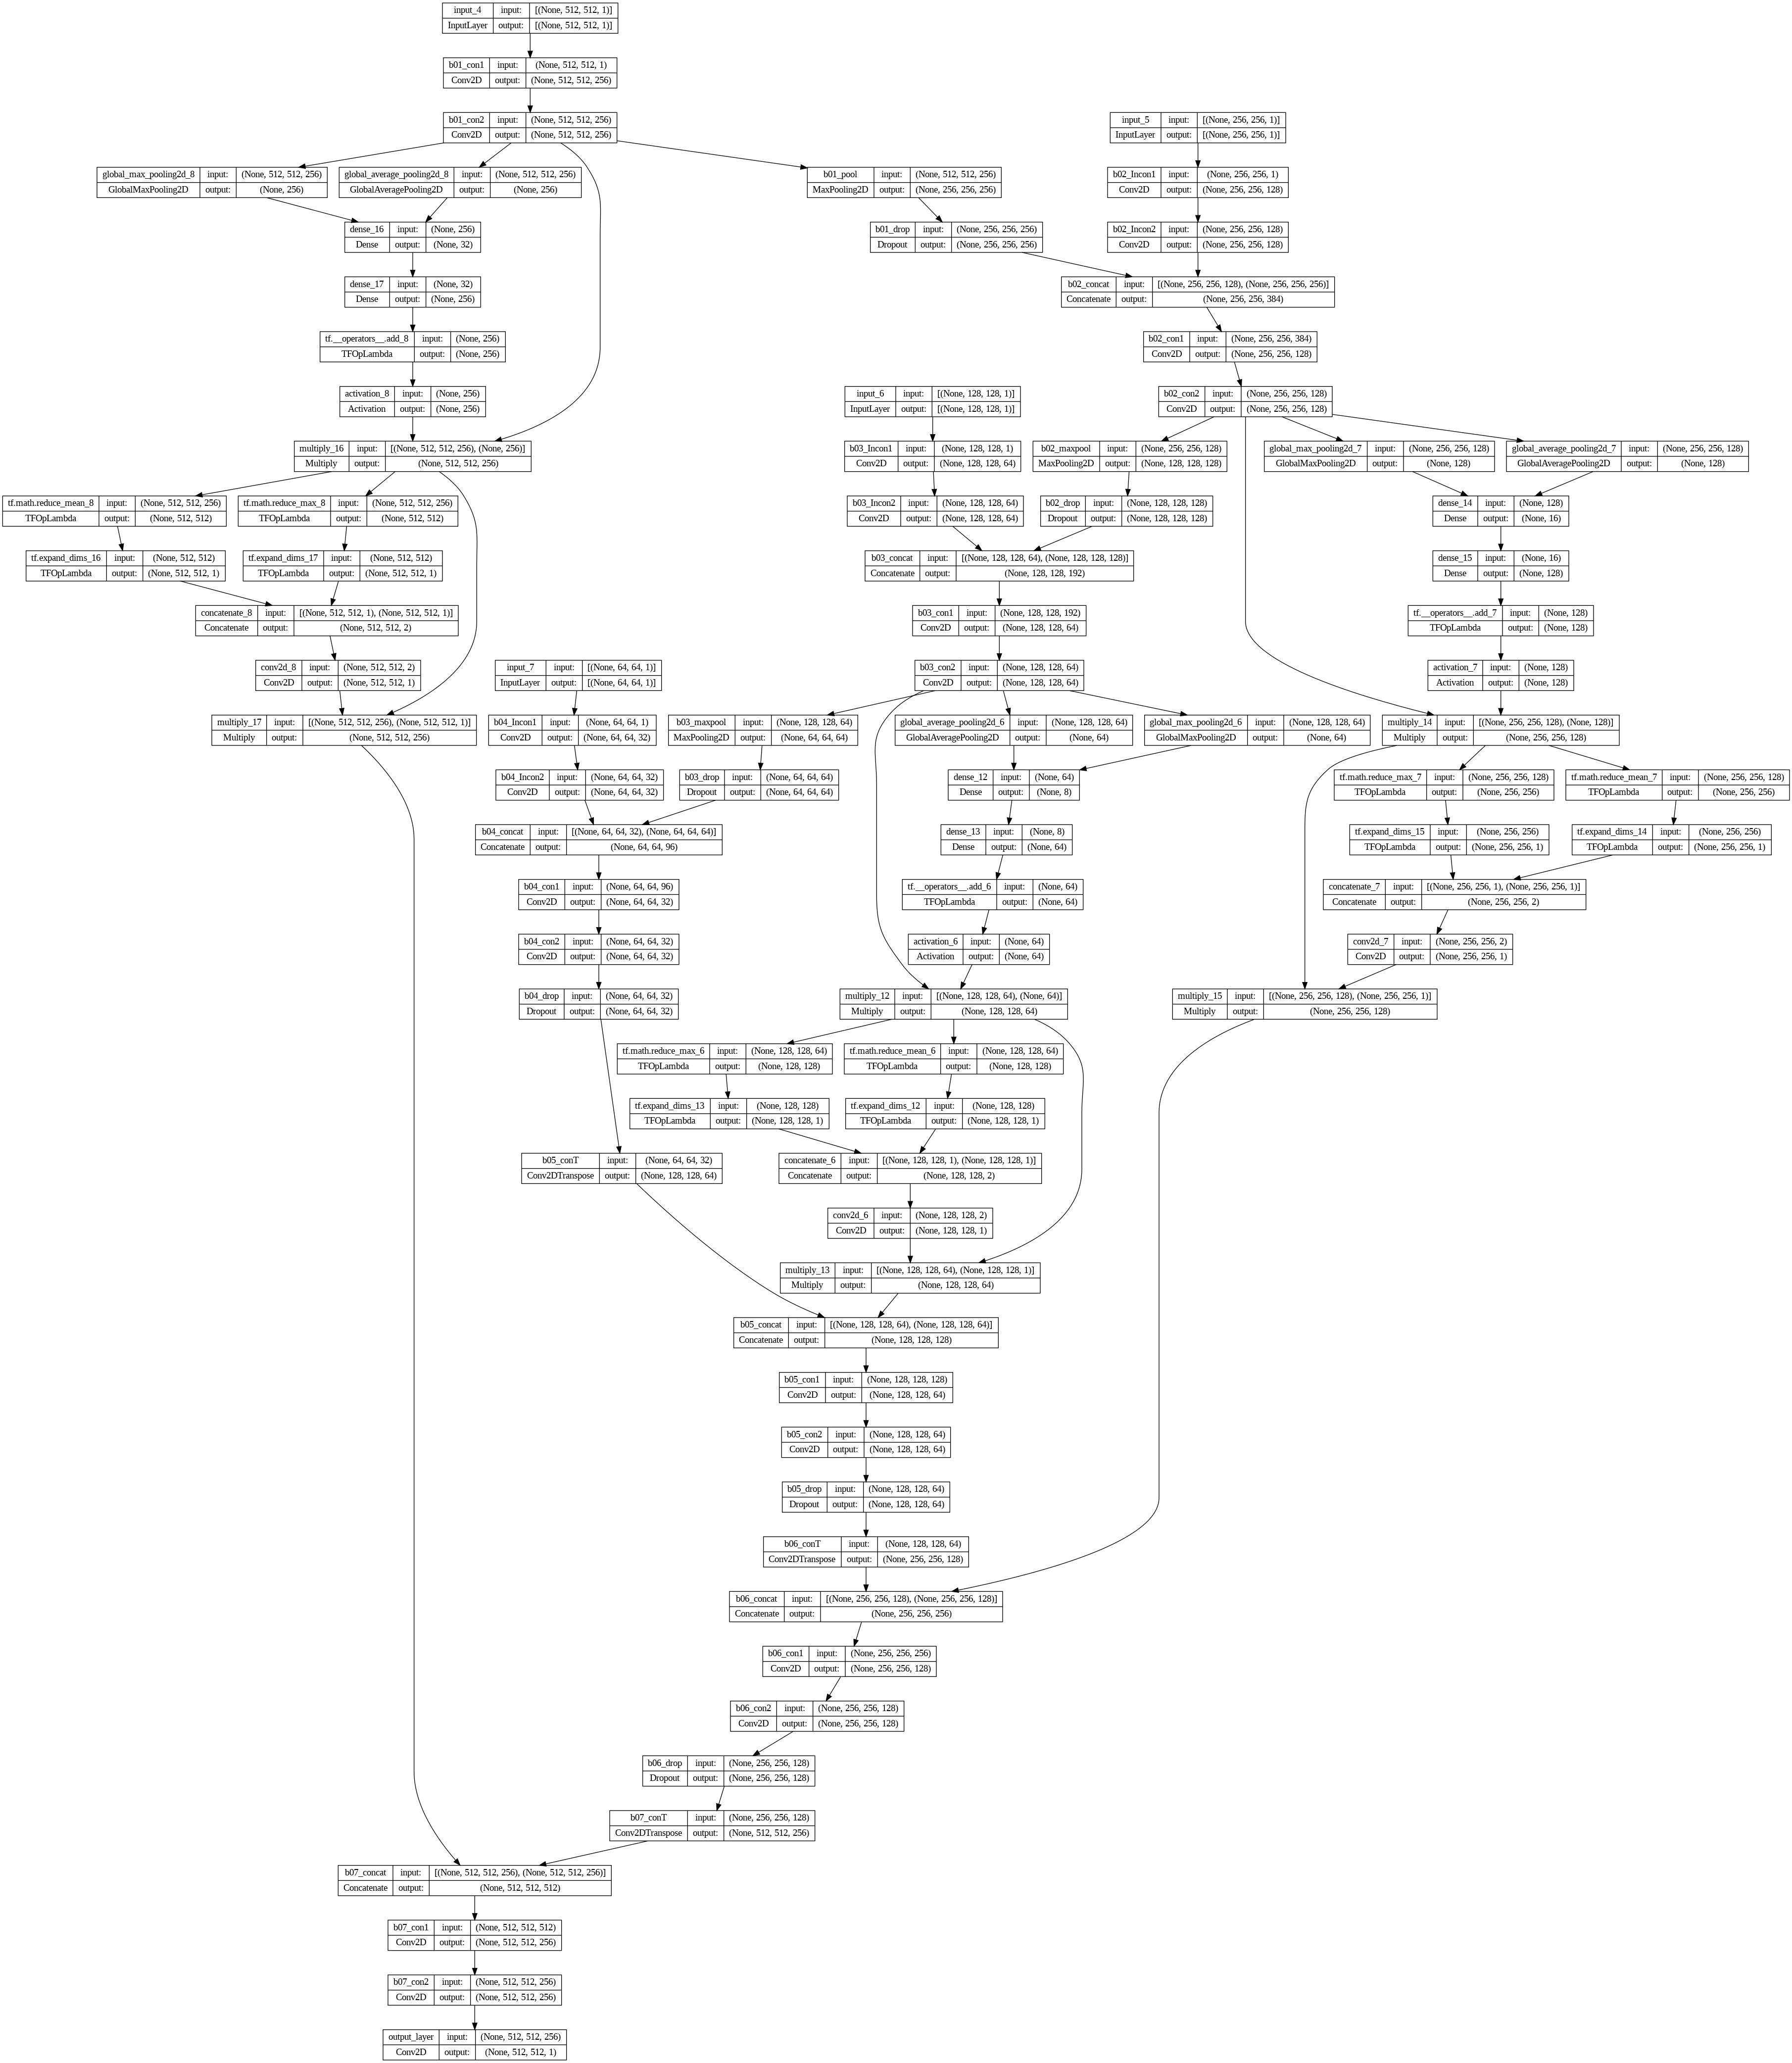

In [ ]:
model = Model(inputs=[input_layer_1, input_layer_2, input_layer_3, input_layer_4], outputs=output_layer)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='base-model_multi_res_CBAM.png')

# Imlementation 02

In [ ]:
input_512 = Input(shape=(512,512,1)) # input_image with one layer (2D image)

# block_01 (Encoder_Layer_01)
b01_con1 = Conv2D(256, (7, 7), activation="relu", padding="same", name='b01_con1')(input_512)
b01_con2 = Conv2D(256, (7, 7), activation="relu", padding="same", name='b01_con2')(b01_con1)

b01_pool = MaxPooling2D((2, 2), name='b01_pool')(b01_con2)
b01_drop = Dropout(0.25, name='b01_drop')(b01_pool)

# block_02 (Encoder_Layer_02)
input_256 = Resizing(256, 256, name='resizing_to_256')(input_512)
b02_Incon1 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b02_Incon1')(input_256)
b02_Incon2 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b02_Incon2')(b02_Incon1)

b02_concat = concatenate([b02_Incon2, b01_drop], name='b02_concat')

b02_con1 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b02_con1')(b02_concat)
b02_con2 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b02_con2')(b02_con1)

b02_maxpool = MaxPooling2D((2, 2), name='b02_maxpool')(b02_con2)
b02_drop = Dropout(0.25, name='b02_drop')(b02_maxpool)

# block_03 (Encoder_Layer_03)
input_128 = Resizing(128, 128, name='resizing_to_128')(input_512)
b03_Incon1 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b03_Incon1')(input_128)
b03_Incon2 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b03_Incon2')(b03_Incon1)

b03_concat = concatenate([b03_Incon2, b02_drop], name='b03_concat')

b03_con1 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b03_con1')(b03_concat)
b03_con2 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b03_con2')(b03_con1)

b03_maxpool = MaxPooling2D((2, 2), name='b03_maxpool')(b03_con2)
b03_drop = Dropout(0.25, name='b03_drop')(b03_maxpool)

# block_04 (Encoder_Layer_04 middle)
input_64 = Resizing(64, 64, name='resizing_to_64')(input_512)
b04_Incon1 = Conv2D(32, (7, 7), activation="relu", padding="same", name='b04_Incon1')(input_64)
b04_Incon2 = Conv2D(32, (7, 7), activation="relu", padding="same", name='b04_Incon2')(b04_Incon1)

b04_concat = concatenate([b04_Incon2, b03_drop], name='b04_concat')

b04_con1 = Conv2D(32, (7, 7), activation="relu", padding="same", name='b04_con1')(b04_concat)
b04_con2 = Conv2D(32, (7, 7), activation="relu", padding="same", name='b04_con2')(b04_con1)

b04_drop = Dropout(0.25, name='b04_drop')(b04_con2)

# block_05 (Decoder_Layer_01)
b05_conT = Conv2DTranspose(64, (7, 7), strides=(2, 2), padding="same", name='b05_conT')(b04_drop)

b05_cbam_skip = cbam(b03_con2)
b05_concat = concatenate([b05_cbam_skip, b05_conT], name='b05_concat')

b05_con1 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b05_con1')(b05_concat)
b05_con2 = Conv2D(64, (7, 7), activation="relu", padding="same", name='b05_con2')(b05_con1)
b05_drop = Dropout(0.25, name='b05_drop')(b05_con2)

# block_06 (Decoder_Layer_02)
b06_conT = Conv2DTranspose(128, (7, 7), strides=(2, 2), padding="same", name='b06_conT')(b05_drop)

b06_cbam_skip = cbam(b02_con2)
b06_concat = concatenate([b06_cbam_skip, b06_conT], name='b06_concat')

b06_con1 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b06_con1')(b06_concat)
b06_con2 = Conv2D(128, (7, 7), activation="relu", padding="same", name='b06_con2')(b06_con1)
b06_drop = Dropout(0.5, name='b06_drop')(b06_con2)

# block_07 (Decoder_Layer_03)
b07_conT = Conv2DTranspose(256, (7, 7), strides=(2, 2), padding="same", name='b07_conT')(b06_drop)

b07_cbam_skip = cbam(b01_con2)
b07_concat = concatenate([b07_cbam_skip, b07_conT], name='b07_concat')

b07_con1 = Conv2D(256, (7, 7), activation="relu", padding="same", name='b07_con1')(b07_concat)
b07_con2 = Conv2D(256, (7, 7), activation="relu", padding="same", name='b07_con2')(b07_con1)

output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid", name='output_layer')(b07_con2)

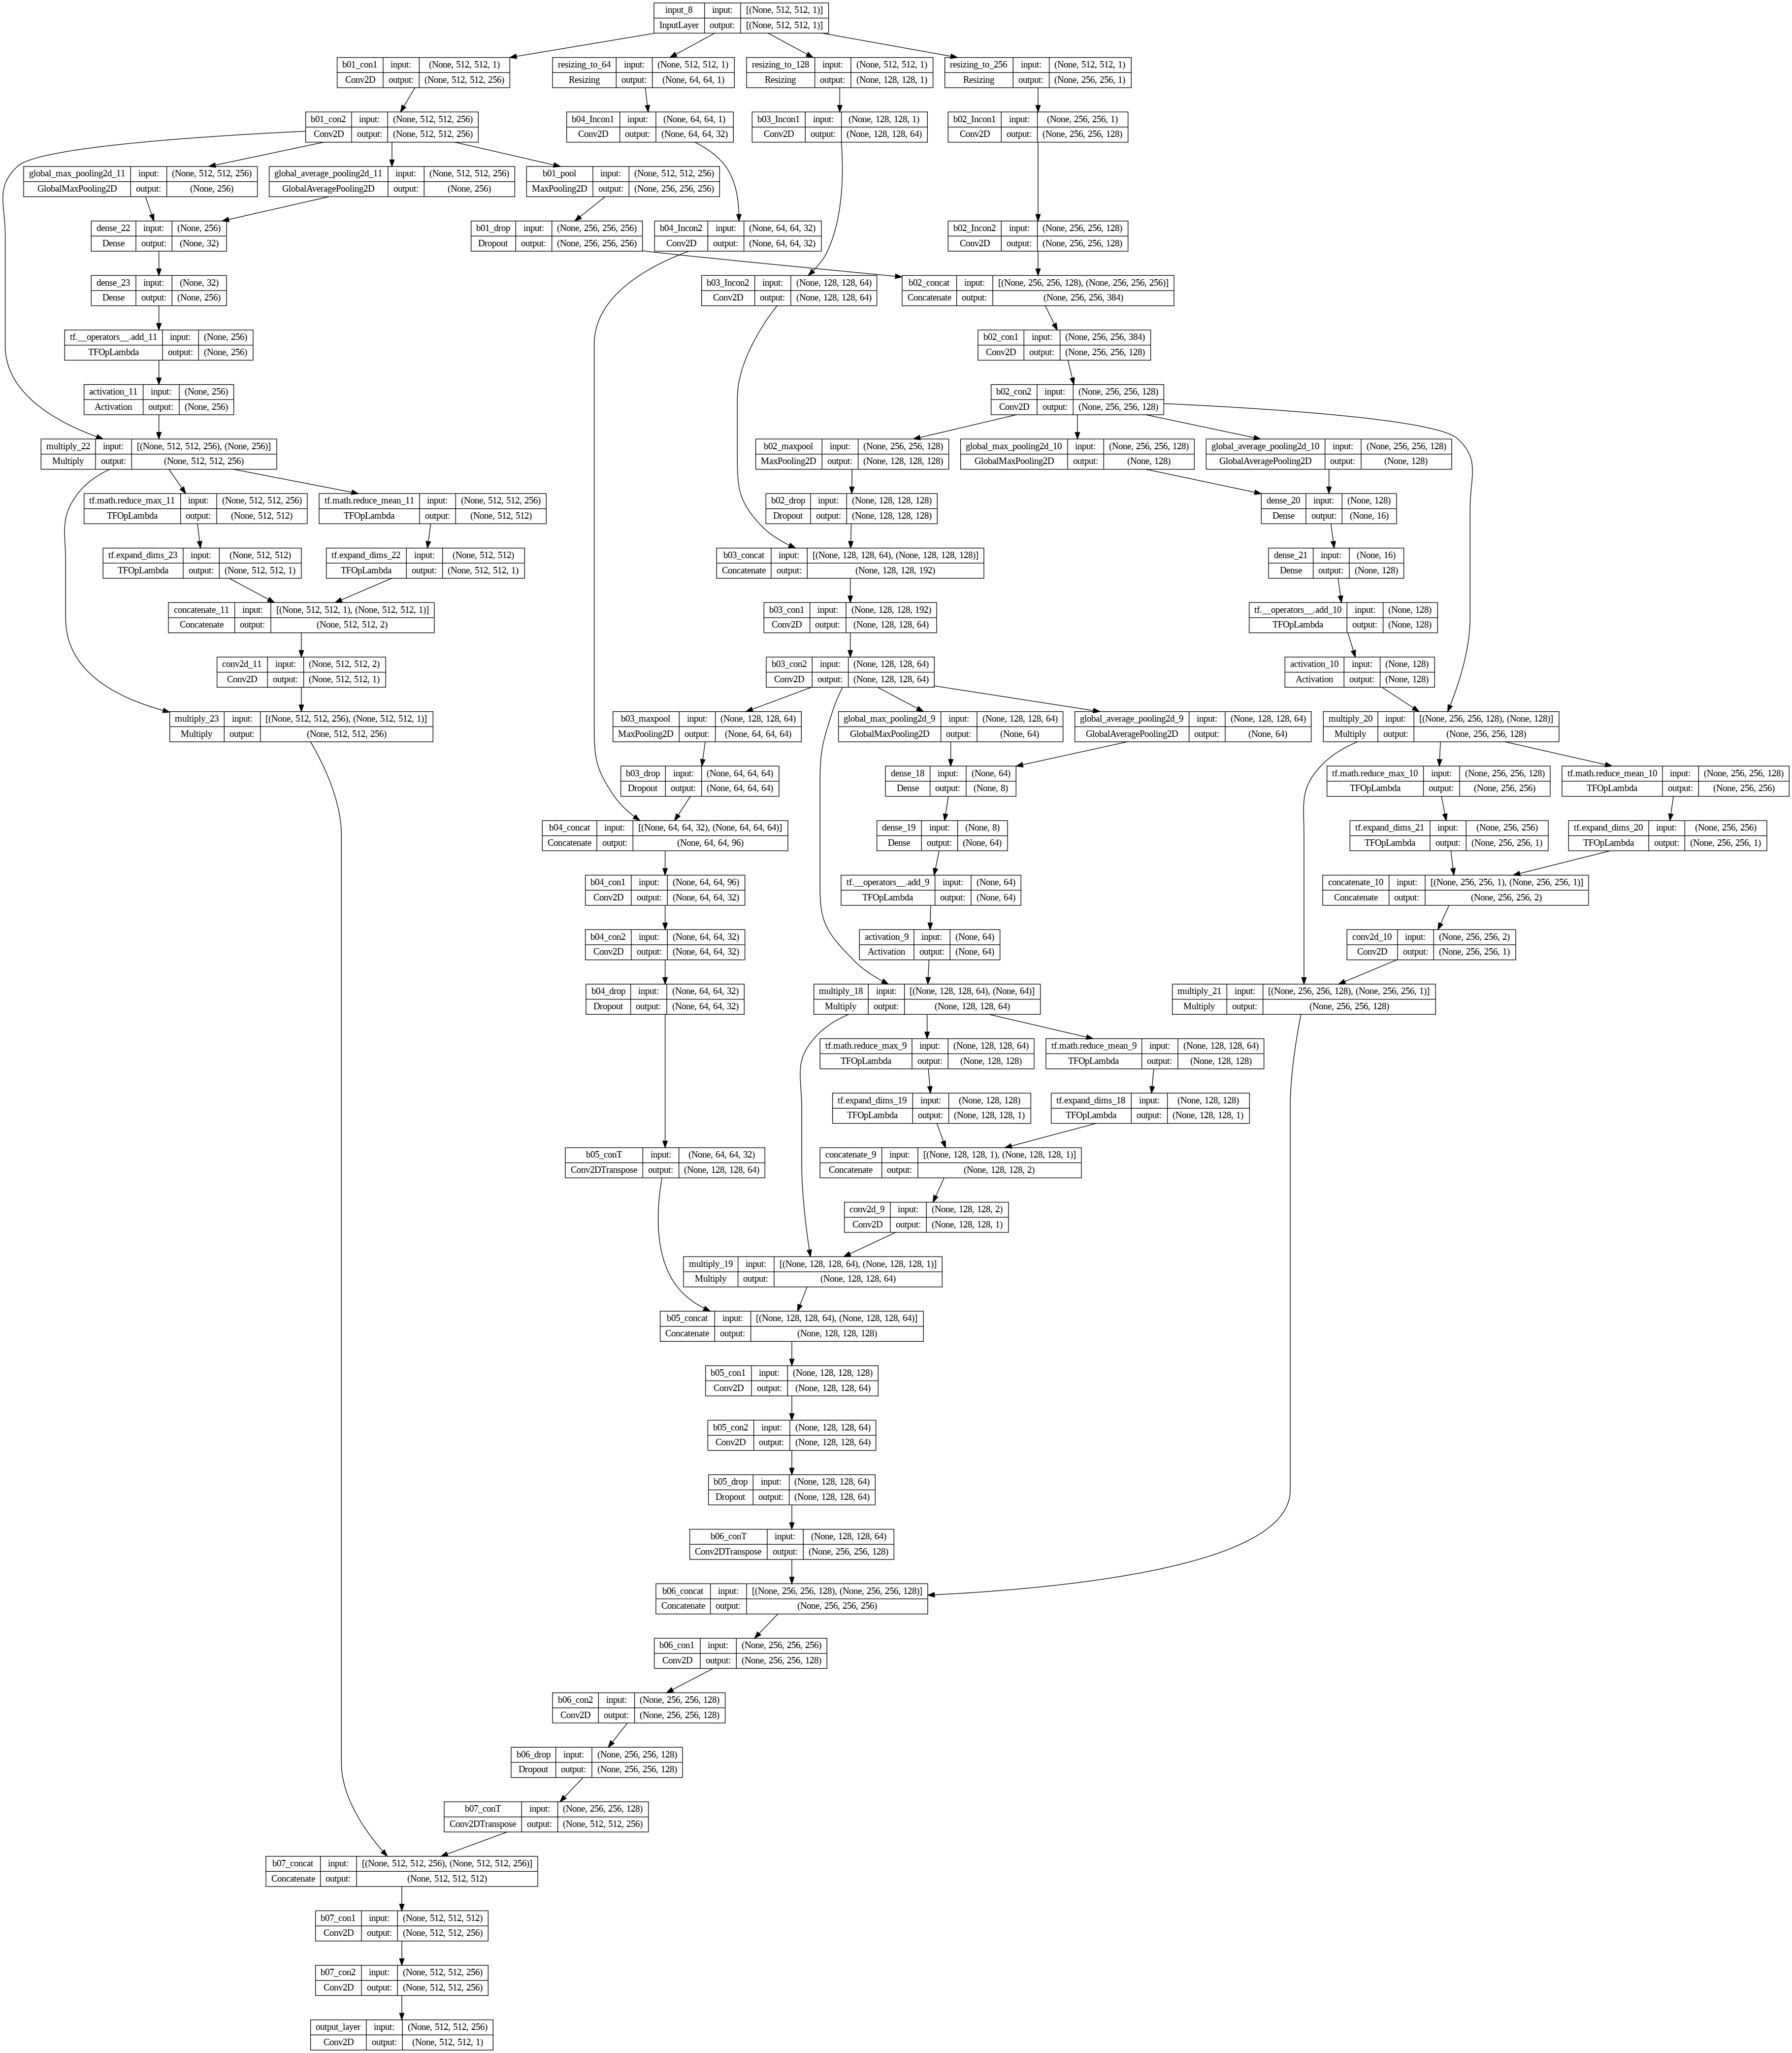

In [ ]:
model = Model(inputs=input_512, outputs=output_layer)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='base-model_multi_res_CBAM.png')